# Weather project for "Python: Data Analysis" LinkedIn course

__Exploring history of weather in Kyiv, using data from station "KIEV, UP", Network:ID "GHCND:UPM00033345". Location: Ukrainian Hydrometeorological Institute. The largest set of data: from 1881-01-01 to 2020-07-20. Latitude / Longitude: 50.4000° / 30.5331°, Elevation: 166 m__

I'm using open data from Global Historical Climatology Network - (GHCN).

This is data service from the USA National Oceanic and Atmospheric Administration, NOAA / National Centers for Environmental Information, NCEI (former National Climatic Data Center, NCDC)


Besides training tasks from Data Analysis cource (to find and visualize a data for US cities), I'm interested in changing of winter temperatures over the years for Kyiv city, Ukraine, - my home city.

General algorithm:

- find station in list: ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt (or https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt)

- download dataset named "UPM00033345.dly" from ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/all/ (or https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/all/)

- parse the file using description in readme.txt https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt from GHCN

- to get overall picture for temperatures over all years

- to process the data - if there are gaps, NANs

- to extract needed parameters - daily TMAX, TMIN and their time references

- to build dependencies of TMAX, TMIN on specified timing

In [611]:
from io import StringIO
import numpy as np
import matplotlib.pyplot as pp
import seaborn

In [487]:
%matplotlib inline

## How to parse data file

In [488]:
with open('readme.txt','r') as f:
    [print(line) for line in f.readlines()[105:155]]

Each record in a file contains one month of daily data.  The variables on each

line include the following:



------------------------------

Variable   Columns   Type

------------------------------

ID            1-11   Character

YEAR         12-15   Integer

MONTH        16-17   Integer

ELEMENT      18-21   Character

VALUE1       22-26   Integer

MFLAG1       27-27   Character

QFLAG1       28-28   Character

SFLAG1       29-29   Character

VALUE2       30-34   Integer

MFLAG2       35-35   Character

QFLAG2       36-36   Character

SFLAG2       37-37   Character

  .           .          .

  .           .          .

  .           .          .

VALUE31    262-266   Integer

MFLAG31    267-267   Character

QFLAG31    268-268   Character

SFLAG31    269-269   Character

------------------------------



These variables have the following definitions:



ID         is the station identification code.  Please see "ghcnd-stations.txt"

           for a complete list of stations and

## Parsing of datafile using numpy

In [489]:
def parsefile(filename):
    return np.genfromtxt(filename,
                         delimiter = dly_delimiter,
                         usecols = dly_usecols,
                         dtype = dly_dtype,
                         names = dly_names)

In [490]:
dly_delimiter = [11,4,2,4] + [5,1,1,1] * 31
dly_usecols = [1,2,3] + [4*i for i in range(1,32)]
dly_dtype = [np.int32,np.int32,(np.str_,4)] + [np.int32] * 31
dly_names = ['year','month','obs'] + [str(day) for day in range(1,31+1)]

In [491]:
kyiv = parsefile('UPM00033345.dly')

In [553]:
kyiv

array([(1881, 1, 'TMAX',    22,    10,   -21,     1,     6,   -15,   -16,   -11,   -72,   -82,   -40,   -62,  -109,   -66,  -135,  -125,  -115,   -84,  -140,   -60,   -71,  -124,  -109,  -111,  -107,   -86,  -155,  -151,   -65,   -38,   -45),
       (1881, 1, 'TMIN',    -6,   -55,   -72,   -51,   -69,   -51,   -88,   -69,  -144,  -152,  -100,  -116,  -164,  -127,  -197,  -200,  -150,  -154,  -181,  -145,  -136,  -156,  -159,  -177,  -189,  -171,  -202,  -212,  -160,   -71,   -65),
       (1881, 1, 'PRCP',     0,     0,     0,     0,     0,     0,     0,     0,     6,     0,     0,     0,    46,    30,     0,     0,    12,     0,     5,    36,     1,     0,     0,     0,     0,     0,     0,     0,     4,     0,     0),
       ...,
       (2020, 6, 'TMIN', -9999, -9999,    55, -9999, -9999,   143, -9999, -9999,   193, -9999,   204, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999),
       (2020, 6,

## Extracting monthly record from a row in dataset

In [493]:
def unroll(record):
    startdate = np.datetime64('{}-{:02}'.format(record['year'],record['month']))
    dates = np.arange(startdate,startdate + np.timedelta64(1,'M'),np.timedelta64(1,'D'))
    
    rows = [(date,record[str(i+1)]/10) for i,date in enumerate(dates)]    
    
    return np.array(rows,dtype=[('date','M8[D]'),('value','d')])

In [555]:
unroll(kyiv[-1])

array([('2020-06-01',   11.8), ('2020-06-02',    9.7),
       ('2020-06-03',   11.6), ('2020-06-04',   13.8),
       ('2020-06-05',   17.7), ('2020-06-06',   21.1),
       ('2020-06-07',   23.6), ('2020-06-08',   23.7),
       ('2020-06-09',   25.9), ('2020-06-10',   25.9),
       ('2020-06-11',   27.6), ('2020-06-12',   27.8),
       ('2020-06-13',   25.3), ('2020-06-14',   20.3),
       ('2020-06-15',   22.9), ('2020-06-16',   23.7),
       ('2020-06-17',   22. ), ('2020-06-18',   22.4),
       ('2020-06-19',   23.9), ('2020-06-20',   22.1),
       ('2020-06-21',   24.7), ('2020-06-22',   23.3),
       ('2020-06-23', -999.9), ('2020-06-24', -999.9),
       ('2020-06-25', -999.9), ('2020-06-26', -999.9),
       ('2020-06-27', -999.9), ('2020-06-28', -999.9),
       ('2020-06-29', -999.9), ('2020-06-30', -999.9)],
      dtype=[('date', '<M8[D]'), ('value', '<f8')])

## Extracting full record of specific observables (e.g. TMAX, TMIN) from all dataset

In [495]:
def getobs(filename,obs):
    data = np.concatenate([unroll(row) for row in parsefile(filename) if row[2] == obs])
    
    data['value'][data['value'] == -999.9] = np.nan
    
    return data

In [609]:
kyiv_tmax = getobs('UPM00033345.dly','TMAX')
kyiv_tmin = getobs('UPM00033345.dly','TMIN')
kyiv_tavg = getobs('UPM00033345.dly','TAVG')  # average temperature

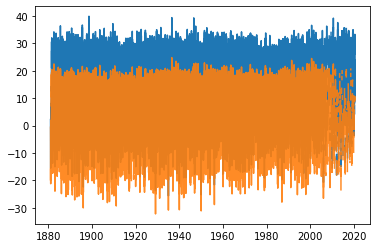

In [571]:
pp.plot(kyiv_tmax['date'],kyiv_tmax['value'],alpha=1)
pp.plot(kyiv_tmin['date'],kyiv_tmin['value'],alpha=0.9)
pp.show()

In [596]:
def plot_smoothed(t,win=10):
    smoothed = np.correlate(t['value'],np.ones(win)/win,'same')
    
    pp.plot(t['date'],smoothed)

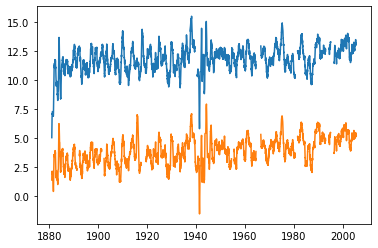

In [645]:
plot_smoothed(kyiv_tmax,365)
plot_smoothed(kyiv_tmin,365)

In [597]:
print(len(kyiv_tmax), len(kyiv_tmin))

50524 50281


### We have not equal quantity of tmax and tmin records! Seems TMAX / TMIN rows are missing for whole month?

Let's make function to check specific year. And let's see 2015:

In [628]:
def select_year(obs, year):
    
    start = np.datetime64('{}'.format(year))
    end = start + np.timedelta64(1, 'Y')
        
    data = np.array([row for row in obs if ((row['date']>=start) & (row['date']<end))])
    
    return data

In [629]:
tmax2015 = select_year(kyiv_tmax, 2015)
tmin2015 = select_year(kyiv_tmin, 2015)
tavg2015 = select_year(kyiv_tavg, 2015)  # average temperature

tmin2015

array([('2015-01-01',  -8.2), ('2015-01-02',  -0.3),
       ('2015-01-03',   nan), ('2015-01-04',   nan),
       ('2015-01-05',   nan), ('2015-01-06',   nan),
       ('2015-01-07',   nan), ('2015-01-08',   nan),
       ('2015-01-09', -12.4), ('2015-01-10',  -0.1),
       ('2015-01-11',   0.6), ('2015-01-12',   nan),
       ('2015-01-13',   0.6), ('2015-01-14',   nan),
       ('2015-01-15',   nan), ('2015-01-16',  -5. ),
       ('2015-01-17',  -1.6), ('2015-01-18',   nan),
       ('2015-01-19',   nan), ('2015-01-20',  -0.1),
       ('2015-01-21',   0. ), ('2015-01-22',  -0.4),
       ('2015-01-23',   nan), ('2015-01-24',   nan),
       ('2015-01-25',   nan), ('2015-01-26',  -3.5),
       ('2015-01-27',  -2.7), ('2015-01-28',  -3.7),
       ('2015-01-29',  -2.2), ('2015-01-30',  -1.1),
       ('2015-01-31',   nan), ('2015-02-01',  -2.6),
       ('2015-02-02',   nan), ('2015-02-03',   nan),
       ('2015-02-04',   nan), ('2015-02-05',  -1.2),
       ('2015-02-06',   nan), ('2015-02-07',  

In [630]:
print('TMAX:', len(tmax2015), 'TMIN:', len(tmin2015), 'TAVG:', len(tavg2015))

TMAX: 365 TMIN: 335 TAVG: 365


### TMIN data for one month is missing in 2015. 

Let's find anomalies through all years:

In [631]:
def chk_year(year):
 
    tmaxrows = 0
    tminrows = 0
    tavgrows = 0
    for row in kyiv:
        if row['year']==year:
            if row[2] == 'TMAX':
                tmaxrows+=1
            if row[2] == 'TMIN':
                tminrows+=1
            if row[2] == 'TAVG':
                tavgrows+=1
            
    return tmaxrows, tminrows, tavgrows

### All years with missing data:

In [665]:
miss_years = []
for year in range(1881,2020):
    tmaxrows,tminrows, tavgrows = chk_year(year)
    
    if (tmaxrows!=tminrows) or (tmaxrows!=12):
        print(year,tmaxrows,tminrows, tavgrows)
        miss_years.append(year)


1881 10 10 12
1883 11 11 12
1884 10 10 12
1916 12 10 12
1918 11 11 11
1938 11 11 11
1941 8 8 8
1943 9 8 9
1946 12 11 12
2015 12 11 12
2016 12 10 12
2019 12 11 12


### Set of years with full record:

In [694]:
all_years = []
for year in range(1881,2020):
    all_years.append(year)

set_mis_year = set(miss_years)
set_all_years = set(all_years)
full_years = set_all_years.difference(set_mis_year)

In [684]:
def plot_year(year):
    pp.plot(select_year(kyiv_tmin, year)['date'],select_year(kyiv_tmin, year)['value'])
    pp.plot(select_year(kyiv_tmax, year)['date'],select_year(kyiv_tmax, year)['value'])
    
    pp.show()

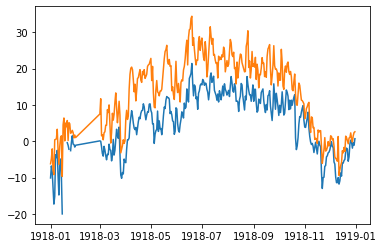

In [685]:
plot_year(1918)

In [547]:
def raw_year(year):
    
    return np.array([row for row in kyiv if row['year'] == year])

In [549]:
print(raw_year(2015))

[(2015,  1, 'TMAX', -9999,    38,    44,    16,     2, -9999,  -108,   -84,    24,    31,    50,    31,    61,    95,    41,    -4,    11,    16,    14,     7, -9999, -9999, -9999, -9999,   -20,    -6,     3, -9999,    33, -9999,    81)
 (2015,  1, 'TMIN',   -82,    -3, -9999, -9999, -9999, -9999, -9999, -9999,  -124,    -1,     6, -9999,     6, -9999, -9999,   -50,   -16, -9999, -9999,    -1,     0,    -4, -9999, -9999, -9999,   -35,   -27,   -37,   -22,   -11, -9999)
 (2015,  1, 'PRCP',     3, -9999, -9999,    10,     3,    10, -9999, -9999, -9999,    30, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,    56,   117,    20,     0,    36, -9999, -9999,    15,     0, -9999, -9999,    10,   104)
 (2015,  1, 'SNWD', -9999, -9999, -9999,    20,    10,    10,    20,    20,    20,    41, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,   150,   119,    79,    71,    30,    20,    30,    41,    30,    41,    30, -9999)
 (2015,  1, 'TAVG',   -23,    13,    26,     5,    -

In [618]:
tmax0 = StringIO(u"UPM00033345201910TMAX-9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   ")
tmin0 = StringIO(u"UPM00033345201910TMIN-9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   ")

In [619]:
empty_tmax = parsefile(tmax0)

In [620]:
empty_tmax

array((2019, 10, 'TMAX', -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999),
      dtype=[('year', '<i4'), ('month', '<i4'), ('obs', '<U4'), ('1', '<i4'), ('2', '<i4'), ('3', '<i4'), ('4', '<i4'), ('5', '<i4'), ('6', '<i4'), ('7', '<i4'), ('8', '<i4'), ('9', '<i4'), ('10', '<i4'), ('11', '<i4'), ('12', '<i4'), ('13', '<i4'), ('14', '<i4'), ('15', '<i4'), ('16', '<i4'), ('17', '<i4'), ('18', '<i4'), ('19', '<i4'), ('20', '<i4'), ('21', '<i4'), ('22', '<i4'), ('23', '<i4'), ('24', '<i4'), ('25', '<i4'), ('26', '<i4'), ('27', '<i4'), ('28', '<i4'), ('29', '<i4'), ('30', '<i4'), ('31', '<i4')])

### Data processing: filling of NANs

In [686]:
def fillnans(data):
    data1 = data.copy()
    dates_float = data1['date'].astype(np.float64)
    
    nan = np.isnan(data1['value'])
    
    data1['value'][nan] = np.interp(dates_float[nan],dates_float[~nan],data1['value'][~nan])
    return data1

In [687]:
kyiv_tmax_filled = fillnans(kyiv_tmax)
kyiv_tmin_filled = fillnans(kyiv_tmin)
kyiv_tmax_filled

array([('1881-01-01',  2.2), ('1881-01-02',  1. ), ('1881-01-03', -2.1),
       ..., ('2020-06-28', 29.4), ('2020-06-29', 29.4),
       ('2020-06-30', 29.4)], dtype=[('date', '<M8[D]'), ('value', '<f8')])

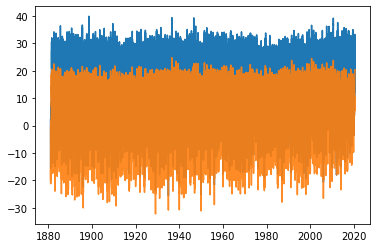

In [688]:
pp.plot(kyiv_tmax_filled['date'],kyiv_tmax_filled['value'], alpha=1)
pp.plot(kyiv_tmin_filled['date'],kyiv_tmin_filled['value'], alpha=0.9)
pp.show()

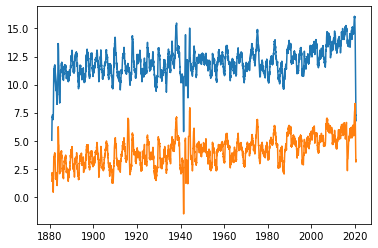

In [689]:
plot_smoothed(kyiv_tmax_filled,365)
plot_smoothed(kyiv_tmin_filled,365)

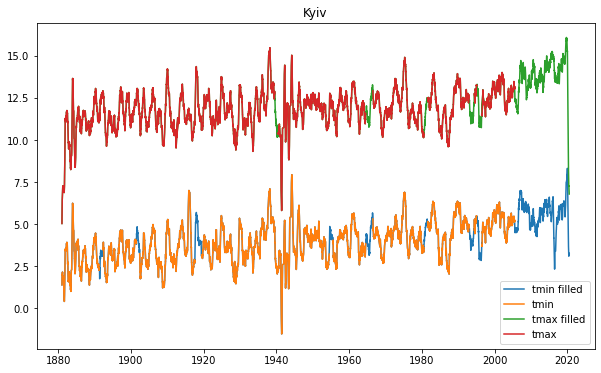

In [690]:
pp.figure(figsize=(10,6))
plot_smoothed(kyiv_tmin_filled,365)
plot_smoothed(kyiv_tmin,365)
plot_smoothed(kyiv_tmax_filled,365)
plot_smoothed(kyiv_tmax,365)
pp.legend(['tmin filled','tmin','tmax filled','tmax',])
pp.title('Kyiv')
pp.show()

### Extracting yearly information

In [691]:
def selectyear(data,year):
    start = np.datetime64('{}'.format(year))
    end = start + np.timedelta64(1,'Y')
    
    return data[(data['date'] >= start) & (data['date'] < end)]['value']

In [700]:
tmax80 = selectyear(kyiv_tmax_filled, 1980)
tmin80 = selectyear(kyiv_tmin_filled, 1980)

array([  3.7,   3.7,  -0.7,   0.5,   1.2,  -0.5,  -2.2,  -3.5,  -6.9,
       -10.2,  -9.5,  -7.4,  -5.2,  -4.9,  -6.4,  -5.3,  -4.4,  -5.7,
        -6.3,  -4.3,  -5.8,  -8.1,  -7.2,  -1.3,   0.9,   1. ,  -1.7,
        -9.2,  -8.2,  -8.2,   4. ,   6.3,   5.1,  -1.4,  -0.8,   1. ,
         1.2,   1.7,   1.9,   1.9,   0.7,  -3.1,  -4.7,  -7.4,  -6.3,
        -4.2,  -2.2,  -0.3,  -3.5,  -2.2,  -3.5,  -1.6,  -1.1,   1.8,
        -2. ,  -3.9,  -1.8,  -4.2,  -4.8,  -4.6,  -1.8,   4.6,   0.6,
        -0.7,  -2.7,   0.9,  -0.5,  -0.1,  -1. ,   1.5,   0. ,  -3.3,
        -1.8,  -0.5,   2.1,   3. ,   4. ,   2. ,  -2.5,  -2.8,  -4.1,
        -2.5,  -1. ,  -2.5,  -2.3,   0.4,   2.1,   1.8,   5.1,   7.2,
         3.7,   8.1,   9.5,   6.4,  11.6,   3.6,  10.4,   8.9,   5.4,
         6.3,  10.5,   8.8,   5.9,  11.4,   8.4,   8.7,   9.5,   8.9,
        16.5,  12.3,  10. ,  12. ,  11.9,  14.9,  11.6,  16.4,  18.4,
        13.2,  13.7,  18.4,  22.3,  21.3,  18.2,  12. ,  10.1,  10.3,
         9.3,  14.1,

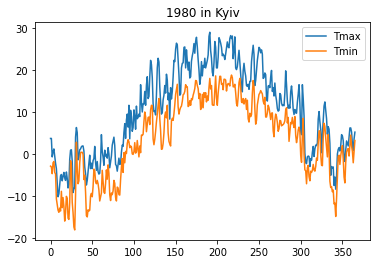

In [693]:
pp.plot(tmax80)
pp.plot(tmin80)
pp.title('1980 in Kyiv')
pp.legend(['Tmax','Tmin'])
pp.show()

In [695]:
kyiv_tmin_all = np.vstack([selectyear(kyiv_tmin_filled,year)[:365] for year in full_years])
kyiv_tmax_all = np.vstack([selectyear(kyiv_tmax_filled,year)[:365] for year in full_years])
kyiv_tmin_all

array([[ -5.        ,  -4.8       ,  -4.4       , ..., -10.2       ,
          2.        ,  -4.4       ],
       [ -6.5       , -10.4       , -10.6       , ...,  -7.8       ,
        -11.6       ,  -6.        ],
       [-12.2       ,  -7.8       ,  -3.2       , ...,  -5.2       ,
         -3.6       ,   1.6       ],
       ...,
       [ -2.5       ,  -1.1       ,   0.2       , ...,  -8.8       ,
         -8.6       ,  -8.4       ],
       [ -1.        ,  -1.66666667,  -2.33333333, ...,   4.8       ,
          3.13333333,   1.46666667],
       [ -0.2       ,   1.7       ,   1.9       , ...,  -1.4       ,
         -2.5       ,  -2.5       ]])

In [696]:
kyiv_tmin_recordmin = np.min(kyiv_tmin_all,axis=0)
kyiv_tmin_recordmax = np.max(kyiv_tmin_all,axis=0)

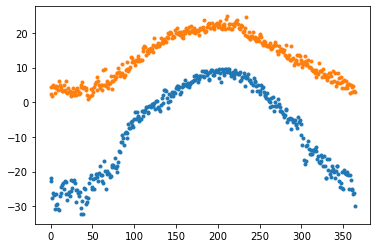

In [697]:
pp.plot(kyiv_tmin_recordmin,'.')
pp.plot(kyiv_tmin_recordmax,'.')

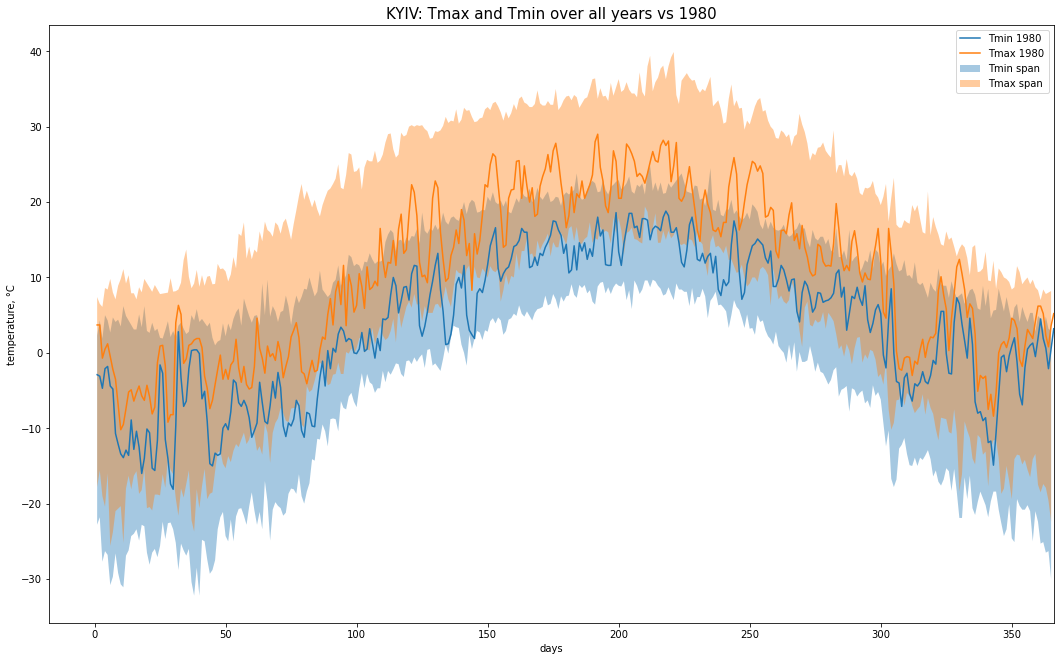

In [698]:
pp.figure(figsize=(18,11))

days = np.arange(1,366)
days1 = np.arange(1,367)
pp.fill_between(days,np.min(kyiv_tmin_all,axis=0),np.max(kyiv_tmin_all,axis=0),alpha=0.4)
pp.fill_between(days,np.min(kyiv_tmax_all,axis=0),np.max(kyiv_tmax_all,axis=0),alpha=0.4)

pp.plot(days1, selectyear(kyiv_tmin_filled,1980))
pp.plot(days1, selectyear(kyiv_tmax_filled,1980))

pp.axis(xmax=366)
pp.xlabel('days')
pp.ylabel('temperature, °C')
pp.title('KYIV: Tmax and Tmin over all years vs 1980', fontsize=15)
pp.legend(['Tmin 1980','Tmax 1980','Tmin span','Tmax span'])
pp.show()

In [717]:
def selectwinter(obs,year):
    
    start = np.datetime64('{}'.format(year)) - np.timedelta64(1, 'M')
    end = start + np.timedelta64(3, 'M')
        
    data = np.array([row for row in obs if ((row['date']>=start) & (row['date']<end))])
    
    return data

In [724]:
w80min = selectwinter(kyiv_tmin, 1982)
w80max = selectwinter(kyiv_tmax, 1982)

In [726]:
print(np.mean(w80min['value']), np.mean(w80max['value']))

-5.738888888888889 -0.20333333333333334


In [708]:
len(kyiv_tmax[:60])

60

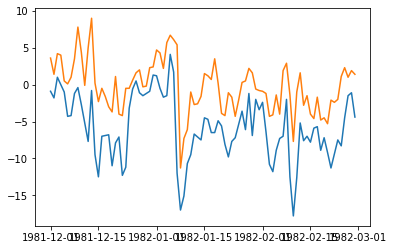

In [729]:
pp.plot(w80min['date'],w80min['value'])
pp.plot(w80max['date'],w80max['value'])
pp.show()

In [781]:
mmin = [(np.datetime64('{}'.format(year)),np.mean(selectwinter(kyiv_tmin_filled,year)['value'])) 
         for year in range(1882,2020)]
winter_mean_min = np.array(mmin, dtype=[('date','datetime64[Y]'),('value','d')])

mmax = [(np.datetime64('{}'.format(year)),np.mean(selectwinter(kyiv_tmax_filled,year)['value'])) 
         for year in range(1882,2020)]
winter_mean_max = np.array(mmax, dtype=[('date','datetime64[Y]'),('value','d')])

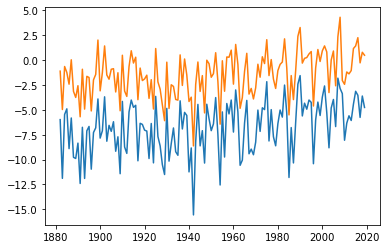

In [782]:
pp.plot(winter_mean_min['date'],winter_mean_min['value'])
pp.plot(winter_mean_max['date'],winter_mean_max['value'])

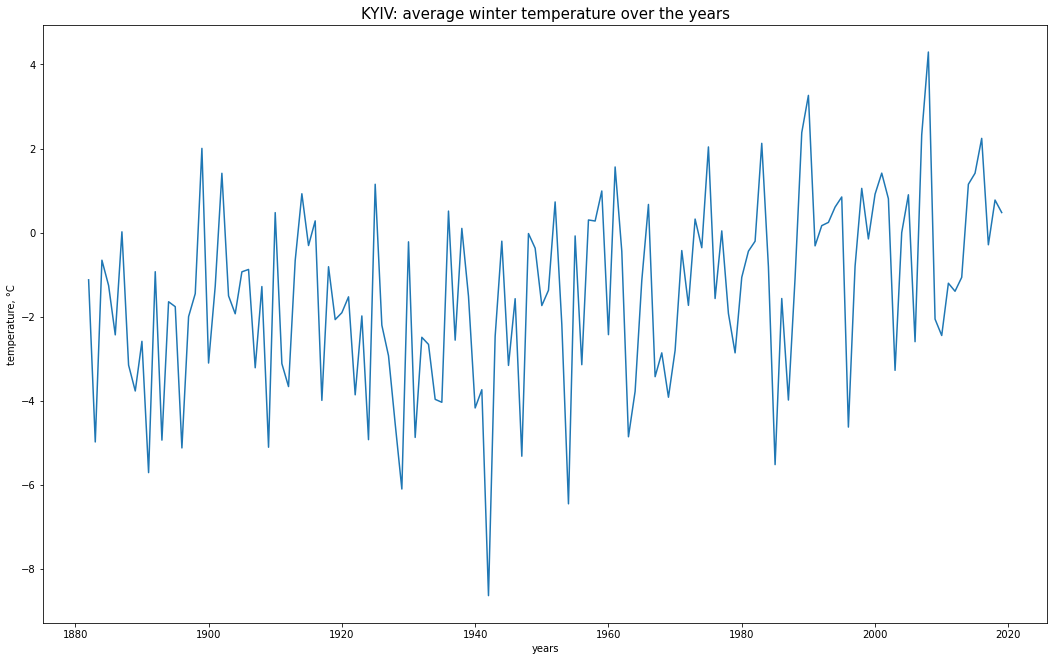

In [785]:
pp.figure(figsize=(18,11))
pp.plot(winter_mean_max['date'],winter_mean_max['value'])
pp.xlabel('years')
pp.ylabel('temperature, °C')
pp.title('KYIV: average winter temperature over the years', fontsize=15)
#pp.legend(['Tmax 1980','Tmax 1980','Tmin span','Tmax span'])
pp.show()

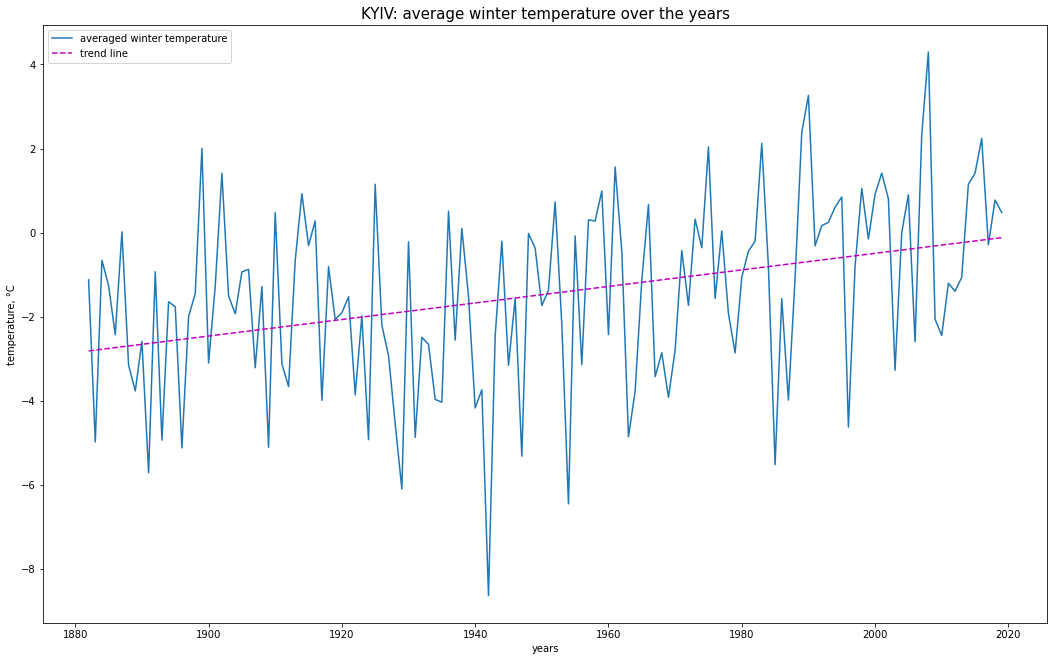

In [803]:
pp.figure(figsize=(18,11))
years = np.arange(1882,2020)
pfit = np.polyfit(years,winter_mean_max['value'], 1)
trend_line_model = np.poly1d(pfit)
pp.plot(years,winter_mean_max['value'])
pp.plot(years, trend_line_model(years), "m--")
pp.xlabel('years')
pp.ylabel('temperature, °C')
pp.title('KYIV: average winter temperature over the years', fontsize=15)
pp.legend(['averaged winter temperature','trend line'])
pp.show()